In [2]:
#%run -i '../../scripts/utility_readblt.py' 'mumu'

In [1]:
from utility_common import *
from utility_plotter import *
import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

Welcome to JupyROOT 6.13/02


# 1. Read data and MC as dataframe

In [2]:
selection  = "mumu"
pickledir  = "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)

In [3]:
def prepare_df_list(nbjetcut):
    cuts = GetSelectionCut("mumu") + "& (nBJets{})".format(nbjetcut)

    Data = LoadDataframe(pickledir + "data2016").query(cuts)
    MCzz = LoadDataframe(pickledir + "mcdiboson").query(cuts)
    MCdy = LoadDataframe(pickledir + "mcdy").query(cuts)
    MCt  = LoadDataframe(pickledir + "mct").query(cuts)
    MCtt = LoadDataframe(pickledir + "mctt").query(cuts)
    
    MCsg = pd.concat([MCt,MCtt],ignore_index=True)

    MCsgf = MCsg.query('(genCategory >= 16) ') # semilep and had
    MCsg0 = MCsg.query('genCategory in [1,3,4,5,6,7,8,9,10,11,12]') #other lep
    MCsg1 = MCsg.query('genCategory in [2]') #mumu
    MCsg2 = MCsg.query('genCategory in [13,14,15]') #mutau

    return [MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,Data],MCt,MCtt

# 2. Plot kinematics

In [4]:
pp = pd.read_csv("plotparameters.csv")
label_list = ['Diboson','V+Jets', r'$tt/tW \rightarrow l + had$',
              r'$tt/tW \rightarrow ll$ other',
              r'$tt/tW \rightarrow \mu + \mu$',
              r'$tt/tW \rightarrow \mu+ \tau$',
              'data']
color_list = ["#a32020", "#e0301e", "#eb8c00", "#49feec", "deepskyblue", "mediumpurple", "k"]

In [7]:
for nbjetcut in ["==1",">1",">=1"]:
    df_list,_,__ = prepare_df_list(nbjetcut)
    plotoutdir = GetPlotDir(selection, nbjetcut)
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        
        plotter = SelectionPlotter(v,a,b,step,df_list)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)

        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

finish all making plots


# 3. Counting

In [5]:
nbjetcut = ">=1"
df_list,MCt,MCtt = prepare_df_list(nbjetcut)
ctr = SelectionCounter()

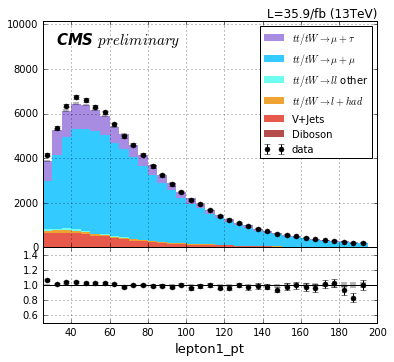

In [6]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton1_pt",25,200,5,"lepton1_pt"
plotter = SelectionPlotter(v,a,b,step,df_list)
plotter.settingPlot(xl,label_list,color_list,plotWithoutXsErr=False)
plotter.makePlot()

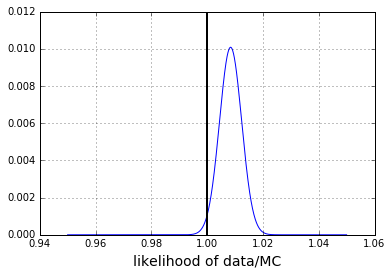

In [7]:
ratio = plotter.hdata/plotter.mctot
err   = sqrt((plotter.hdata**0.5/plotter.mctot)**2 + (plotter.mcerr/plotter.mctot)**2)


x = np.linspace(0.95,1.05,1000)
l = np.ones_like(x)
for i in range(len(ratio)):
    norm = (1/sqrt(2*np.pi*err[i]**2))
    l *= norm*np.exp(-(x-ratio[i])**2/(2*err[i]**2))
    #nll = nll+(x-ratio[i])**2/(2*err[i]**2)
l = l/np.sum(l)

plt.plot(x,l)
plt.xlabel("likelihood of data/MC",fontsize=14)
plt.axvline(1,c="k",lw=2)
plt.grid()

np.save("dataMCRatio/mumu_095to105", l)

In [7]:
print("(nBJets{})".format(nbjetcut))
print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets==1)
MCtt: [0, 271460, 297, 0, 2155, 7, 0, 29, 0, 0, 23, 0, 52, 52112, 364, 0, 5139, 2, 406, 0, 3]
MCtt width: [0.0, 257460.0588704687, 250.81809615762904, 0.0, 1995.4688748016488, 4.893205776810646, 0.0, 27.554583817720413, 0.0, 0.0, 22.289065301418304, 0.0, 44.83300681016408, 48734.921078588464, 321.8788404385559, 0.0, 4550.211435906156, 2.2414177656173706, 354.1899142397742, 0.0, 2.5451186895370483]
MCt : [0, 1833, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 1, 372, 3, 0, 42, 0, 1, 0, 0]
MCt width: [0.0, 1763.500702716905, 0.0, 0.0, 12.329632185399532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5144170522689819, 354.26961600908544, 3.045598328113556, 0.0, 34.857424216810614, 0.0, 0.2623654305934906, 0.0, 0.0]


In [8]:
ctr.countSlt_Scaled(df_list)

data:70372.0
TotalMC:70359.28658751969
------ MC break down ------
[  187.35759304  7033.57110772   989.4197778    458.37285569
 51786.26053374  9904.30471954]


In [9]:
for thisdf in [df_list[0],df_list[1], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))

7033.57,73.81
989.42,15.44
2816.79,61.33
60321.56,108.49
70372.00,265.28


In [10]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 407605.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5158.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]
